# Adaptive PDE discretizations on cartesian grids
## Volume : Divergence form PDEs
## Part : Applications
## Chapter : Extracting geodesics from the heat kernel

This notebook is a numerical illustration of *Varadhan's formula*, which relates Riemannian geodesics and eikonal equations, with the heat kernel.
We also present a variant of this method, devoted to Rander metrics, which are asymmetric perturbations of Riemannian metrics featuring a drift term.

**References**

The numerical scheme used for anisotropic diffusion in this notebook is taken from:
* Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3

The Varadhan formula was first numerically illustrated in:
* Crane, K., Weischedel, C., & Wardetzky, M. (2013). Geodesics in heat: A new approach to computing distance based on heat flow. ACM Transactions on Graphics (TOG), 32(5), 152.

## Anisotropic diffusion and Riemannian distances : Varadhan's formula

**An elliptic equation.** 
Let $\Omega \subset R^d$ be a bounded domain, and let $D : \Omega \to S_d^{++}$ be a field of diffusion tensors. 
Consider the elliptic optimization problem 
$$
    \min \int_\Omega \epsilon^2 | \nabla u(x)|^2_{D(x)} + u(x)^2\, dx
$$
subject to Dirichlet boundary conditions on a nonempty subset $\Gamma_D \subset \partial \Omega$ of the domain boundary 
$$
    u=1 \text{ on } \Gamma_D,
$$
and Neuman boundary conditions on $\partial\Omega \setminus \Gamma_D$. 
In the interior of the domain, the above optimization problem can be rephrased in the form of an elliptic partial differential equation
$$
    u(x) - \epsilon^2 \mathrm{div} (D(x) \nabla u(x)) = 0.
$$

**Relation with the eikonal equation.**
Following the Hopf-Cole approach to the linearization of Burger's PDE, extended by Varhadan to multi-dimensional Poisson and diffusion equations, we rely on a logarithmic transformation of the unknown.

Denote by $u_\epsilon$ the solution to the previous PDE on $\Omega$.
Under adequate assumptions, one can show that 
$$
    v_\epsilon := -\epsilon \ln u_\epsilon
$$
converges as $\epsilon \to 0^+$ to the distance function from $\Gamma_D$ on $\Omega$, measured with respect to the metric $M(x) := D(x)^{-1}$ which is the inverse to the diffusion tensors. 
A justification for this fact is that the PDE
$$
    |\nabla v(x)|_{D(x)}^2 - \epsilon \mathrm{div}( D(x) \nabla v(x)) = 1
$$
is satisfied on $\Omega$, along with the Dirichlet boundary condition $v=0$ on $\Gamma_D$.
As $\epsilon \to 0$, the viscosity introduced by the second order operator vanishes, and one recovers the eikonal equation $|\nabla v(x)|_{D(x)} = 1$.

**Interpretation as a path length.**
Consider the Riemannian metric 
$$
    M(x) := D(x)^{-1},
$$
for all $x \in \Omega$.
Let us recall that the unique viscosity solution to the above eikonal equation, with Dirichlet boundary conditions on $\Gamma_D$ and outflow boundary conditions on $\partial \Omega \setminus \Gamma_D$, is the distance map from $\Gamma_D$:
$$
    v(x) = \inf_\gamma \int_0^1 \| \gamma'(t)\|_{M(\gamma(t))} dt
$$
where $\gamma : [0,1] \to \Omega$ has locally Lipschitz regularity, and is subject to the constraints:
$$
    \gamma(0) \in \Gamma_D, \quad \gamma(1) = x.
$$
Once the distance map $v$ is numerically computed, or approximated, one can backtrack the corresponding minimal geodesics $\gamma$ using a gradient flow method.

### Remarks on Varadhan's formula
**Optional refinement.**
Crane et al suggest a simple additional non-linear step to improve the accuracy of the reconstructed distance map $v$. While interesting, this method is not discussed in this notebook. 
Note also that this extra-step is:
- incompatible with the Sinkhorn algorithm, discussed in the next notebook.
- regarded as un-necessary if one is interested in the minimal geodesic paths rather than the geodesic distance itself.

**Non-divergence form variant.**
A non-divergence form equation can be considered, instead of the above divergence form elliptic equation:
$$
    u(x) - \epsilon^2 \mathrm{tr} (D(x) \nabla^2 u(x)) = 0,
$$
for all $x \in \Omega$. This modification has little impact on the results, since the introduced first order term is negligible. See the end of this notebook for the introduction of a non-negligible first order term, in the context of Randers metrics.

**Parabolic (time dependent) variant.**
Another variant of Varadhan's formula involves the time-dependent heat equation, which is the following the parabolic PDE
$$
    \partial_t u(t,x) - \mathrm{div} (D(x) \nabla u(t,x)).
$$



[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic metrics](#1.-Isotropic-metrics)
    * [1.1 Reproducing the Euclidean distance](#1.1-Reproducing-the-Euclidean-distance)
    * [1.2 Effect of the relaxation parameter $\epsilon$](#1.2-Effect-of-the-relaxation-parameter-$\epsilon$)
    * [1.3 The Poincare half plane model](#1.3-The-Poincare-half-plane-model)
  * [2. Anisotropic Riemannian metrics](#2.-Anisotropic-Riemannian-metrics)
    * [2.1 Geodesic distance on a surface](#2.1-Geodesic-distance-on-a-surface)
    * [2.2 Metric definition in term of eigenvectors and eigenvalues](#2.2-Metric-definition-in-term-of-eigenvectors-and-eigenvalues)
  * [3. Rander metrics](#3.-Rander-metrics)
    * [3.1 Generalized Varadhan formula](#3.1-Generalized-Varadhan-formula)
    * [3.2 Constant Rander metric](#3.2-Constant-Rander-metric)
    * [3.3 Zermelo's problem with a variable drift](#3.3-Zermelo's-problem-with-a-variable-drift)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('VaradhanGeodesics','Div')

In [2]:
from agd import LinearParallel as lp
from agd import LinearPDE
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Selling
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

In [3]:
import numpy as np
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 
from matplotlib import pyplot as plt

### 0.1 Utility functions

The following function is used throughout the notebook to estimate distances associated to isotropic, riemannian, or Randers metrics. 

In [4]:
def VaradhanDistance(diff,rhs,dx,ϵ=None,ω=None,divergenceForm=None):
    """
    Approximate a Riemannian distance using Varadhan's formula.
    Input.  
    - diff : diffusion tensors D(x), inverse of the riemannian metric. Alternatively : diffusion coefficients d(x).
    - rhs : right-hand-side of linear system. (Typically zero everywhere except at seed points.)
    - h : grid scale
    - ϵ : relaxation parameter
    - ω : first order term, used with asymmetric Rander metrics
    - divergenceForm : None -> use the finite difference scheme implemented in this notebook
            True/False -> use ad-hoc routine to build the matrix, with or without div form
    """
    shape,ndim,size = rhs.shape,rhs.ndim,rhs.size
    
    if ϵ is None: # Produce a default value for the relaxation parameter ϵ
        tdiff = diff if diff.shape==shape else lp.trace(diff)
        δ = np.sqrt(np.max(tdiff)) # length scale associated with a field of diffusion tensors
        ϵ = 2 * δ * dx 
    
    if divergenceForm is None: # Operator matrix generated from this notebook's schemes
        u_ad = ad.Sparse2.identity(shape)
        if diff.shape==shape: # Isotropic
            solution = IsotropicEnergy(  u_ad, ϵ**2*diff, rhs, dx).solve_stationnary()
        elif ω is None: # Riemannian
            solution = AnisotropicEnergy(u_ad, ϵ**2*diff, rhs, dx).solve_stationnary()
        else: # Rander
            v_ad = ad.Sparse2.identity(shape, shift=size) 
            solution = AsymmetricForm(u_ad, v_ad, ϵ**2*diff, ϵ*ω, rhs, dx).solve_weakform()
            
    else: # Operator matrix built directly using external library 
        if diff.shape==shape: diff = diff*fd.as_field(np.eye(ndim),shape)
        coef,(row,col) = LinearPDE.OperatorMatrix(ϵ**2*diff, mult=np.ones_like(rhs), 
            omega=None if ω is None else ϵ*ω, gridScale=dx, 
            boundaryConditions='Neumann',divergenceForm=divergenceForm)
        operator = scipy.sparse.coo_matrix((coef,(row,col))).tocsr()
        solution = scipy.sparse.linalg.spsolve(operator,rhs.flatten())

    # Extract Riemannian distance
    distance  = -ϵ*np.log(solution.reshape(shape))
    distance -= np.min(distance)
    
    return distance

Rather than imposing Dirichlet boundary conditions at the seed points, we introduce of a non-zero right hand side, featuring Dirac-like singularities.

In [5]:
def RangeIndex(rg,x):
    """Find the index of a value x in an equispaced range rg"""
    return int(round( (x-rg[0])/(rg[-1]-rg[0]) * (len(rg)-1)))

def MakeRHS(seeds,axes):
    rhs=np.full(tuple(len(ax) for ax in axes),0.)
    for seed in seeds:
        rhs[tuple(RangeIndex(ax,x) for ax,x in zip(axes,seed))] = 1
    return rhs

## 1. Isotropic metrics

We illustrate Varadhan's formula for isotropic metrics, which are locally proportionnal to the Euclidean metric.
$$
    M(x) = c(x)^2 \mathrm{Id},
$$
where $c : \Omega \to ]0,\infty[$ is a continuous and positive cost function.
The length of a path $\gamma : [0,1] \to \Omega$, w.r.t. this metric, is therefore
$$
    \int_0^1 c(\gamma(t)) \|\gamma(t)\| dt,
$$
and the eikonal equation reads
$$
    \| \nabla v(x)\| = c(x),
$$
for all $x \in \Omega$.

Varadhan's method involves, for this application, solving the elliptic equation
$$
    u(x) - \varepsilon^2 \mathrm{div}( c(x)^{-2} \nabla u(x)) = 0.
$$

**Discretization.** Since the laplacian operator is *isotropic*, i.e. it is defined in terms of an isotropic diffusion tensor $c(x)^{-2} \mathrm{Id}$, the standard five point finite difference scheme is used.


**Geodesic extraction.** Minimal geodesics can be obtained by following the gradient of the distance map. In other words by solving the ordinary differential equation
$$
    \gamma'(t) = V(\gamma(t)),
$$
backwards in time, where for all $x \in \Omega$
$$
    V(x) = \nabla u(x).
$$

### 1.1 Reproducing the Euclidean distance

We compute the Euclidean distance from three points, referred to as *seeds*, in the square domain $[0,1]^2$.
This test can be regarded as a sanity check. The Euclidean metric is obtained by choosing the constant cost $c\equiv 1$ in the above definition of a Riemannian metric.

In [6]:
#Define the domain [0,1]^2, sampled on a cartesian grid
aX,dx = np.linspace(0,1,retstep=True)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

# Generate the diffusion coefficients 
diff = np.ones(X.shape[1:]) # Constant diffusion coefficient
#diff = np.where(X[0]<=0.5,1,4) # Piecewise constant 

# Choose the seeds from which distance is computed
#seeds = [[0.5,0.5]] #Alternatively : single seed in the center
seeds = [[0.3,0.2],[0.8,0.3],[0.5,0.8]] # multiple seeds
rhs = MakeRHS(seeds,(aX,aX))

# Choose a relaxation parameter
ϵ = 2 * dx

**Elliptic energy**

In order to apply Varadhan's method, we implement the energy 
$$
    \frac 1 2 \int_\Omega \big(u^2 + d \|\nabla u\|^2\big) -\int_\Omega f u,
$$
where $d : \Omega \to ]0,\infty[$ is the diffusion coefficient, and $f$ is a right hand side. 




*Question 1*
===
Implémenter une fonction calculant l'énergie ci-dessus.


In [ ]:
def IsotropicEnergy(u,diff,rhs,h):
    """
    Finite differences approximation of 
    (1/2) * ( u^2 + diff * (grad u)^2) - rhs * u 
    """
    # TODO. Hint : fd.DiffUpwind(u,(1,0),h) 

    energy_density = 
    ad.simplify_ad(energy_density) # Faster matrix build
    
    return energy_density.sum() * dx**ndim


In the context of geodesic distance computation by Poisson kernel, one chooses $d(x) = \epsilon^2 c(x)^{-2}$, and $f$ is supported on the seed points.

In [8]:
%%time
distance = VaradhanDistance(diff,rhs,dx,ϵ)

CPU times: user 115 ms, sys: 8.64 ms, total: 123 ms
Wall time: 137 ms


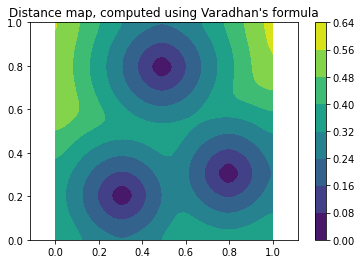

In [9]:
plt.axis('equal'); plt.title("Distance map, computed using Varadhan's formula")
plt.contourf(*X,distance); plt.colorbar();

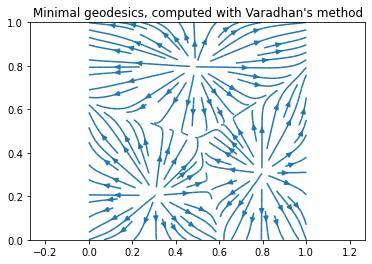

In [10]:
grad = np.gradient(distance,dx)
plt.axis('equal'); plt.title("Minimal geodesics, computed with Varadhan's method")
streamplot_ij(*X,*grad);

For concistency, we check the results using an external library for solving the same problem. (Note that the running time is substantially lower that with the AD implementation. This seems related to entry reordering in the sparse matrix build.)

In [11]:
%%time
distance_div = VaradhanDistance(diff,rhs,dx,ϵ,divergenceForm=True)

CPU times: user 12.7 ms, sys: 3.75 ms, total: 16.5 ms
Wall time: 15.3 ms


In [12]:
assert np.allclose(distance, distance_div)

### 1.2 Effect of the relaxation parameter $\epsilon$


The convergence analysis requires that the gridscale $h$ vanishes faster than the relaxation parameter $\epsilon$, but not too fast, in the sense that :
$$
    (\epsilon,h/\epsilon,\epsilon\ln h) \to 0.
$$

Nevertheless, the best practical results are often obtained when the relaxation parameter $\epsilon$ is a few times larger than the gridscale $h$. In the above example, we set 
$$
    \epsilon = 2 h
$$
which is a reasonable practical choice. (Although, from the theoretical standpoint, it does not ensure convergence, since $h/\epsilon \not \to 0$ under this constraint.) When setting these parameters, beware that:
* An excessively *small* $\epsilon/h$ leads to a *non-convergent* distance.
* An excessively *large* $\epsilon/h$ produces undesirable *numerical diffusion*.

In [14]:
# Setting a too low value of epsilon
distance = VaradhanDistance(diff,rhs,dx,ϵ/10)

If $\epsilon$ is too small, as with the above numerical distance computation, then empirical evidence shows that the the $L^1$ Manhattan distance is (approximately) reproduced, instead of the desired Euclidean distance.

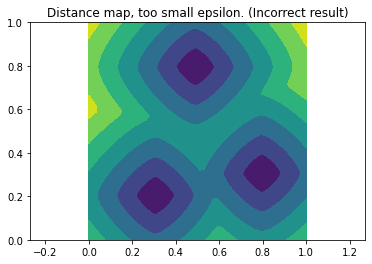

In [15]:
plt.axis('equal'); plt.title("Distance map, too small epsilon. (Incorrect result)")
plt.contourf(*X,distance);

In [16]:
# Setting a too large value of epsilon
distance = VaradhanDistance(diff,rhs,dx,ϵ*10)

If $\epsilon$ is too large, on the other hand, then level sets are not equidistant, which illustrates the lack of accuracy of the obtained numerical approximation of the distance function.

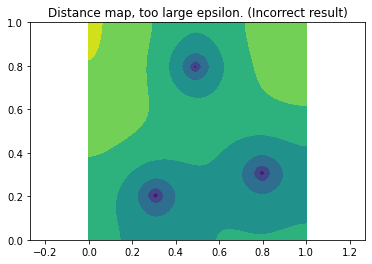

In [17]:
plt.axis('equal'); plt.title("Distance map, too large epsilon. (Incorrect result)")
plt.contourf(*X,distance);

### 1.3 The Poincare half plane model

We illustrate Varadhan's formula on the Poincare model of the half plane, which is one of the geometric instantiations of the hyperbolic plane. (The Poincare disk model is another well known instantiation.)

The Poincare half plane model is posed on the domain $\Omega = \mathbb R \times \mathbb R_+^*$, which is equipped with the following Riemannian metric
$$
    \frac{dx^2 + dy^2} {y^2},
$$
for all $x,y \in \Omega$. Note that the metric is again isotropic.
This numerical example is solved with an alternative method in 
[III - The Fisher information metric](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/B4_FisherRao.ipynb)

Let us set up the Poincare half plane example.





*Question 2*
===
Définissez le coefficient de diffusion correspondant au modèle.


In [ ]:
# Create the domain [-1,1] x [0.3,1.3]
dx = 0.01
aX0 = np.arange(-1,1,dx)
aX1 = np.arange(0.3,1.3,dx)
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

seeds = [[0,0.5]]
rhs = MakeRHS(seeds, (aX0,aX1))

# Define the diffusion coefficient
diff = # TODO


In [19]:
distance = VaradhanDistance(diff,rhs,dx)

Level sets of the Poincare distance are (non concentric) Euclidean disks.

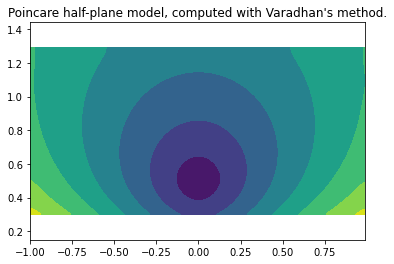

In [20]:
plt.axis('equal'); plt.title("Poincare half-plane model, computed with Varadhan's method.")
plt.contourf(*X,distance);

Geodesics of the Poincare metric are Euclidean cirles.

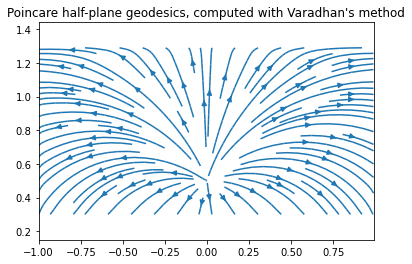

In [21]:
plt.axis('equal'); plt.title("Poincare half-plane geodesics, computed with Varadhan's method")
streamplot_ij(*X,*np.gradient(distance));

We check the consistency with the external library.

In [22]:
assert np.allclose(distance, VaradhanDistance(diff,rhs,dx,divergenceForm=True) )

## 2. Anisotropic Riemannian metrics

Varadhan's formula applies to both isotropic and anisotropic Riemannian metrics. Numerically, the main difficulty in the anisotropic context is to discretize an anisotropic Laplacian. However this point is handled transparently in the provided python function, using techniques described in 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)

Once the geodesic distance $v$ from a given point is computed, the geodesic backtracking ODE reads
$$
    \gamma'(t) = V(\gamma(t)),
$$
similarly to the isotropic case. 
The flow direction is defined as the intrinsic Riemannian gradient of the distance map
$$
    V(x) = D(x) \nabla v(x).
$$
The following numerical examples are solved with an alternative numerical method in 
[II - Riemannian metrics](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A3_Riemannian.ipynb)

**Elliptic energy.**
In order to use Varadhan's method to compute Riemannian distances, we need to implement the elliptic energy
$$
    \frac 1 2 \int_\Omega (u^2 + \| \nabla u\|^2_D) - \int_\Omega f u
$$




*Question 3*
===
Implémentez cette énergie.


In [ ]:
def AnisotropicEnergy(u,diff,rhs,h):
    """
    Finite differences approximation of the integral of 
    (1/2) * ( u^2 + diff * (grad u)^2) - rhs * u
    """
   
    energy_density = # TODO. Hint : Selling.Decomposition(diff)
    ad.simplify_ad(energy_density)
    
    return energy_density.sum() * dx**ndim


### 2.1 Geodesic distance on a surface

We compute the geodesic distance on a parametrized two dimensional surface embedded into $R^3$ and defined by a height map:
$$
    z(x,y) = (3/4) sin(3 \pi  x) \sin(3 \pi y), 
$$
where $(x,y) \in ]-0.5,0.5[^2$. The metric is 
$$
    M(x,y) = \mathrm{Id} + \nabla z(x,y) \nabla z(x,y)^T.
$$





*Question 4*
===
Implementer cette métrique.


In [ ]:
# Create the domain
gridScale = 0.01
aX = np.arange(-0.5,0.5,gridScale); 
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

# Define the metric
Z = (3/4.)*np.sin(3*np.pi*X[0])*np.sin(3*np.pi*X[1])
metric = # TODO. Hint : np.gradient
diff = lp.inverse(metric) 

# Generate the rhs
rhs = MakeRHS([[0.,0.]], (aX,aX))


In [27]:
distance = VaradhanDistance(diff,rhs,dx)

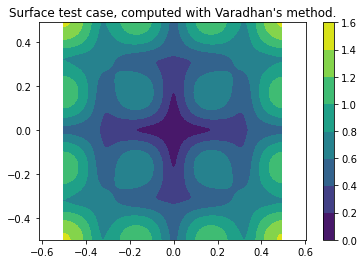

In [28]:
plt.axis('equal'); plt.title("Surface test case, computed with Varadhan's method.")
plt.contourf(*X,distance); plt.colorbar();

In [29]:
flow = lp.solve_AV(metric,np.array(np.gradient(distance)))

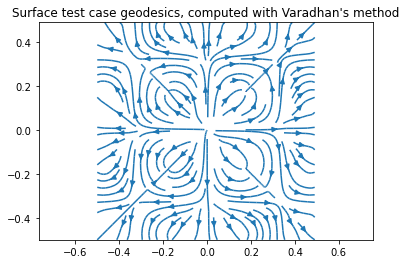

In [30]:
plt.axis('equal'); plt.title("Surface test case geodesics, computed with Varadhan's method")
streamplot_ij(*X,*flow);

In [31]:
assert np.allclose(distance, VaradhanDistance(diff,rhs,dx,divergenceForm=True))

### 2.2 Metric definition in term of eigenvectors and eigenvalues

In this example, the metric tensors are specified by their eigenvectors and eigenvalues
$$
    M(x) = \lambda_1(x)^{-2} v_1(x) v_1(x)^T + \lambda_2(x)^{-2} v_2(x) v_2(x)^T.
$$
The scalars $\lambda_1$ and $\lambda_2$ appearing in this expression should be regarded as the local velocity in the direction of $v_1$ and $v_2$ respectively.

Our specific example involves constant eigenvalues, defined by $\lambda_1 \equiv 0.8$ and $\lambda_2\equiv 0.2$, and an analytic eigenvector $v_1(x_1,x_2) \propto (1, \cos( 2 \pi x_1))$ (normalized) while $v_2$ is orthogonal.

In [32]:
# Create the domain
dx = 0.02
aX = np.arange(-1,1,dx); 
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
shape = X.shape[1:]

# Generate the metric
eig1 = np.stack((np.ones(shape),(np.pi/2)*np.cos(2*np.pi*X[0])))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) )
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)
diff = lp.inverse(metric)

# Generate the rhs
rhs = MakeRHS([[0.,0.]], (aX,aX))

In [33]:
distance = VaradhanDistance(diff,rhs,dx)

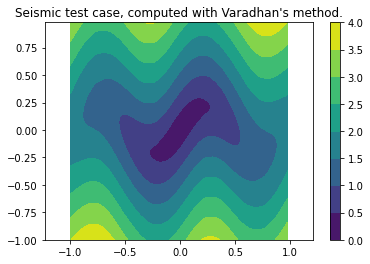

In [34]:
plt.axis('equal'); plt.title("Seismic test case, computed with Varadhan's method.")
plt.contourf(*X,distance); plt.colorbar();

In [35]:
flow = lp.solve_AV(metric,np.array(np.gradient(distance)))

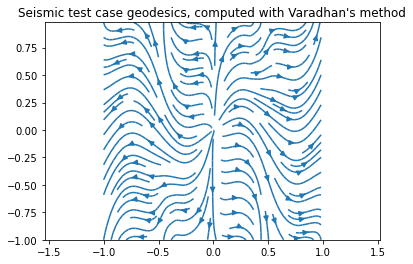

In [36]:
plt.axis('equal'); plt.title("Seismic test case geodesics, computed with Varadhan's method")
streamplot_ij(*X,*flow);

In [37]:
assert np.allclose(distance, VaradhanDistance(diff,rhs,dx,divergenceForm=True))

## 3. Randers metrics

**Optimal control viewpoint.**
Randers metrics are an extension of Riemannian metrics, featuring a drift term. We choose to illustrate them through an optimal control problem, referred to as Zermelo's navigation problem.
Find the shortest time $T = T(x)$, where $x\in \Omega$ is a specified endpoint, for which there exists a path $\gamma : [0,T] \to \Omega$ obeying 
$$
    \|\gamma'(t) - \omega(\gamma(t)) \|_{M(t)} \leq 1
$$
for all $t \in [0,T]$, and subject to the boundary conditions $\gamma(0) \in \Gamma_D$ and $\gamma(T) = x$.

The problem parameters are the Riemannian metric $M$, the drift vector field $\omega$, and the source set $\Gamma_D$. We make the further assumption that 
$$
    \| \omega(x) \|_{M(x)} < 1
$$
for all $x \in \Omega$, otherwise the problem is not locally controllable.

**The eikonal equation.** The arrival time $v(x) := T$ for the above optimal control problem obeys the generalized eikonal PDE
$$
    \| \nabla v(x)\|_{D(x)} + <\omega(x), \nabla v(x)> = 1,
$$
where $D(x) := M(x)^{-1}$ is the inverse of the Riemannian metric.

**Geodesic backtracking.** Minimal paths are extracted by an *intrinsic* gradient descent, taking into account the geometry defined by the Randers metric. More precisely, the backtracking ODE takes the form $\gamma'(t) = V(\gamma(t))$ where
$$
    V(x) := \frac{D(x) \nabla v(x)}{\|\nabla v(x)\|_{D(x)}} + \omega(x).
$$

### 3.1 Generalized Varadhan formula

Consider the elliptic equation
$$
    u + 2\epsilon <\omega,\nabla u> - \epsilon^2 \mathrm{div}(A \nabla u)=0,
$$
where $A$ is a field of positive definite matrices, in a domain $\Omega$. 
Assume e.g. $u=1$ on the boundary $\partial \Omega$.
Then setting $u = e^{-v/\epsilon}$, we find that $v$ obeys the PDE
$$
    \|\nabla v\|_A^2 - \epsilon \mathrm{div}(A \nabla v) = 1 + 2 <\omega, \nabla v>.
$$
Adding $<\omega, \nabla v>^2$ to both sides of this equation we obtain
$$
    \| \nabla v\|_D^2 - \epsilon \mathrm{div}(A \nabla v) = (1 + <\omega, \nabla v>)^2,
$$
where we have set $D := A+\omega\omega^T$ and factored the r.h.s.
Neglecting the viscosity induced by the second order term, which vanishes as $\epsilon \to 0$, taking the square root and rearranging terms we obtain 
$$
    \| \nabla v\|_D - <\omega,\nabla v> =1,
$$
which is the generalized eikonal equation for Randers metrics.

**Numerical scheme.**
The second order term $\mathrm{div}(A \nabla u)$ is discretized as in the Riemannian case, relying on the techniques of 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)

The first order term $2 <\omega,\nabla u>$ is discretized using centered finite differences, in the same direction as the second order differences discretizing the second order term. The resulting discretization is second order consistent, and monotone under adequate assumptions, see below.


**Relaxation parameter.**
The relaxation parameter $\epsilon$ is subject to an additional constraint in the case of Rander metrics.
Indeed, if $\epsilon$ is too small, then the first order term dominates the second order term in Varadhan's formula, and the numerical scheme looses monotony. The resulting numerical solution may in that case present negative values, and the method fails. 

The method presented below involves a relaxation parameter only slightly larger than in the Riemannian case, which is already enough to accomodate fairly strong drifts, see below. Automatic setting of the relaxation parameter for even stronger drifts will be the object ot future research.

In [43]:
def RandersDistance(metric,drift,rhs,dx,**kwargs):
    diff = lp.inverse(metric)
    distance = VaradhanDistance(diff-lp.outer_self(drift),rhs,dx,ω=2*drift,**kwargs)
    grad = np.array(np.gradient(distance,dx))
    flow = lp.dot_AV(diff,grad)
    flow = flow/np.sqrt(lp.dot_VV(flow,grad)) + drift
    return distance, flow

**Bilinear form.** 
The numerical implementation of Varadhan's formula generalized to Randers metrics, requires the discretization of the following asymmetric bilinear form:
$$
    \int_\Omega (u v + <\nabla u, D \nabla v> + <\omega,\nabla u> v)- \int_\Omega fv
$$




*Question 5*
===
Implémenter une approximation par différences finies de la forme bilinéaire ci-dessus.
Partant d'une décomposition
$$
    D = \sum_{1 \leq i \leq I} \rho_i e_i e_i^T
$$
on pourra utiliser l'approximation
$$
    < \omega,\nabla u > = \sum_{1 \leq i \leq I} \omega_i \frac{u(x+h e_i)-u(x-h e_i)} {2h}
$$
où $\omega_i = \rho_i <D^{-1} \omega, e_i>$.


In [ ]:
def AsymmetricForm(u,v,diff,ω,rhs,dx):
    """
    Finite differences discretization of the integral of 
    u*v + <grad u, D grad v> + <ω,u>v - rhs*v
    """
    ρ,e = Selling.Decomposition(diff)
    dup = fd.DiffUpwind(u, e,dx)
    dum = fd.DiffUpwind(u,-e,dx)
    du = fd.DiffCentered(u,e,dx)
    dvp = fd.DiffUpwind(v, e,dx)
    dvm = fd.DiffUpwind(v,-e,dx)

    dup,dum,du,dvp,dvm = [np.where(np.isnan(e),0.,e) for e in (dup,dum,du,dvp,dvm)]
    
    form_density = 
    ad.simplify_ad(form_density)
    
    return form_density.sum()


### 3.2 Constant Rander metric

This example is a sanity check, involving a constant Riemannian metric, namely the Euclidean metric, and a constant drift field in the direction of $(1,1)/\sqrt 2$.
As a result:
- The level sets of the distance map are (non-concentric) circles.
- The minimal geodesic paths a straight lines towards the origin.

In [41]:
# Define the domain
aX,dx = np.linspace(-1,1,100,retstep=True); 
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
shape = X.shape[1:]

# Define the Riemannian metric and the drift
drift = 0.7 * np.ones(2)/np.sqrt(2)
metric = np.eye(2)
drift,metric = [fd.as_field(e,shape) for e in (drift,metric)]

# Set the rhs
rhs = MakeRHS([[0,0]],(aX,aX))

In [44]:
distance,flow = RandersDistance(metric,drift,rhs,dx)

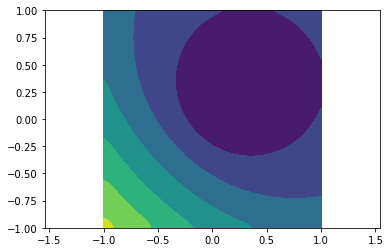

In [45]:
plt.axis('equal');
plt.contourf(*X,distance); 

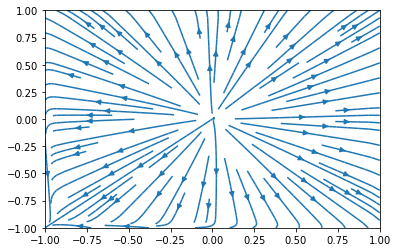

In [46]:
streamplot_ij(*X,*flow);

In [47]:
assert np.allclose(distance,RandersDistance(metric,drift,rhs,dx,divergenceForm=True)[0])

### 3.3 Zermelo's problem with a variable drift

We present an instance of Zermelo's navigation problem, where the vehicle's maximum speed is unit in all directions. The vehicle is however subject to a position dependent drift, with the following analytical expression:
$$
    \omega(x,y) := \rho \sin(2 \pi x) \sin (2 \pi y) \frac{(x,y)}{\|(x,y)\|},
$$
for all $x,y \in [-1,1]^2$. Note that the metric positiveness constraint requires $|\rho| < 1$. We let $\rho := 0.8$.

A different numerical approach for the same problem is presented in the notebook
[III - Rander metrics. Application to Zermelo's navigation problem, and image segmentation](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rander.ipynb)

In [48]:
drift = 0.8*np.sin(2*np.pi*X[0])*np.sin(2*np.pi*X[1]) * X/ np.linalg.norm(X,axis=0)

In [49]:
distance,flow = RandersDistance(metric,drift,rhs,dx)

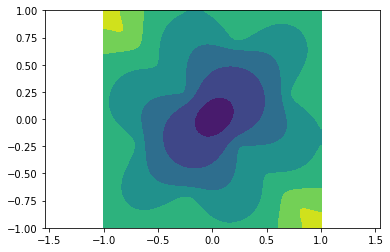

In [50]:
plt.axis('equal');
plt.contourf(*X,distance);

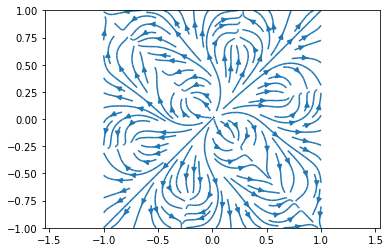

In [51]:
plt.axis('equal')
streamplot_ij(*X,*flow);

In [52]:
assert np.allclose(distance,RandersDistance(metric,drift,rhs,dx,divergenceForm=True)[0])